In [249]:

from statistics import mean, mode
import torch
from torch import nn
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score

In [250]:
import numpy as np

In [251]:
# https://towardsdatascience.com/lstms-in-pytorch-528b0440244
# https://github.com/IHCA-Coding-to-Prevent-Coding/ML-SampleNeuralNet/blob/main/sampleneuralnet.py
# data from https://archive.ics.uci.edu/ml/datasets/Power+consumption+of+Tetouan+city#

In [252]:
data = pd.read_csv('Tetuan City power consumption.csv')
data.columns

Index(['DateTime', 'Temperature', 'Humidity', 'Wind Speed',
       'general diffuse flows', 'diffuse flows', 'Zone 1 Power Consumption',
       'Zone 2  Power Consumption', 'Zone 3  Power Consumption'],
      dtype='object')

In [253]:
# changes data length so you don't run on 50,000 values every time
data = data.iloc[:5000, :]

In [254]:
xValues = data.iloc[:, [1, 2, 3, 4, 5]]
yValues = data.iloc[:, [6]]
assert len(xValues) == len(yValues)

In [255]:
# alternate data splitting that isn't week by week

training, validation, trainTruth, valTruth = train_test_split(xValues, yValues)
validation, testing, valTruth, testTruth = train_test_split(validation, valTruth)

assert len(training)==len(trainTruth)
assert len(testing)==len(testTruth)
assert len(validation) == len(valTruth)

In [256]:
trainTruth = torch.tensor(trainTruth.values)
training = torch.tensor(training.values)

testTruth = torch.tensor(testTruth.values)
testing = torch.tensor(testing.values)

training = training.float()
testing = testing.float()

trainTruth = trainTruth.float()
testTruth = testTruth.float()

valTruth = torch.tensor(valTruth.values)
validation = torch.tensor(validation.values)

validation = validation.float()
valTruth = valTruth.float()

In [257]:
average = mean(x.item() for x in trainTruth)

binaryTestTruth = torch.tensor([float(x>average) for x in testTruth])

binaryTrainTruth = torch.tensor([float(x>average) for x in trainTruth])

binaryValTruth = torch.tensor([float(x>average) for x in valTruth])

c:\Users\natha\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\loss.py:536: UserWarning: Using a target size (torch.Size([3750])) that is different to the input size (torch.Size([3750, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


total change in loss: 0.025226891040802002


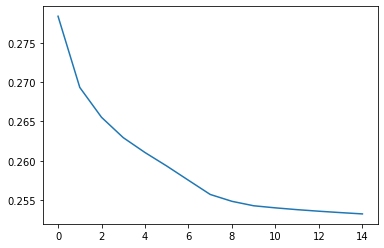

In [258]:
#testing = torch.randn(batchSize, seqLength, inputSize)

inputSize=5 # variables input
hiddenSizeOne=32 # nodes of hidden layer
hiddenSizeTwo=32 # nodes of hidden layer
outSize=1 # power consumptoion in zone 1
batchSize= 144*7 # how many data points are in batch
lr = 0.01
seqLength=144 # num of time values per input
epochSize = 15

class extractTensor(nn.Module):
    def forward(self, x):
        tensor, hs = x
        return tensor.reshape(-1, hiddenSizeOne) 

model = nn.Sequential(
    nn.LSTM(inputSize, hiddenSizeOne),
    extractTensor(),
    #nn.Sigmoid(),
    nn.Linear(hiddenSizeOne, hiddenSizeTwo),
    #nn.Sigmoid(),
    nn.Linear(hiddenSizeTwo, outSize)
    # nn.Sigmoid() 
    #nn.Linear(linearSize, outSize)
)

def lossFunc(data=training, comparison=trainTruth, model=model):
    prediction = model(data)

    MSEloss = torch.nn.MSELoss()
    output = MSEloss(prediction, comparison)
    
    return output, prediction

optimizer = torch.optim.SGD(model.parameters(), lr=lr)


# model training starts here
lossList = []
for i in range(epochSize):
    loss, output = lossFunc(comparison = binaryTrainTruth)
    lossList.append(loss.item())

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

plt.plot(lossList)
training_loss = loss.item();
print(f'total change in loss: {lossList[0]-lossList[-1]}')

In [259]:
with torch.no_grad():
    testing_loss, prediction = lossFunc(validation, binaryValTruth);
    testing_loss = testing_loss.item()
   
    print(f"training loss:    {training_loss}");
    print(f"testing loss:     {testing_loss}");
    print(f"testing-training: {abs(testing_loss-training_loss)}");
    print(f"testing/training: {training_loss/testing_loss}");
    print(f"% error           {abs(testing_loss-training_loss)/testing_loss}");

training loss:    0.2532046139240265
testing loss:     0.25310018658638
testing-training: 0.00010442733764648438
testing/training: 1.0004125928908032
% error           0.00041259289080312314


c:\Users\natha\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\loss.py:536: UserWarning: Using a target size (torch.Size([937])) that is different to the input size (torch.Size([937, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


In [260]:
common = mode([float(x) for x in output])

count=0
for x in output:
    if x == common:
        count+=1

print(f'predicting same thing {count/len(prediction)*100}%')

predicting same thing 0.21344717182497333%


In [261]:
# rounding percentage chances to 1 or 0 floats
binaryPred = []
for pred in prediction:
    if pred.item() >= 0.5:
        binaryPred.append(1.0)
    else:
        binaryPred.append(0)

In [262]:
print(f'AUROC score: {roc_auc_score(binaryValTruth, prediction)}')

AUROC score: 0.49971140896556143


In [263]:
# accuracy for binary prediction

correct=0
for i in range(len(binaryPred)):
    if binaryPred[i] == binaryValTruth[i]:
        correct+=1
print(f'accuracy: {(correct/ len(prediction))*100}')

accuracy: 46.85165421558165


In [264]:
# cross validation is necessary for true model
# iterate above k times
# each iteration change training and testing data (stratified data split probably best imo)
# get average auroc score over all iterations